In [ ]:
#!pip install transformers

In [ ]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from copy import deepcopy
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from transformers import get_cosine_schedule_with_warmup

from torchvision import datasets, transforms
from torch.utils.data import dataloader

In [ ]:
#%cd '/content'

/content


In [ ]:
device = torch.device('cpu')
torch.manual_seed(42)

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.manual_seed_all(42)

In [ ]:

"""
순서
어텐션
MLP(피드포워드)
인코더 블록
인코더
"""
"""
나머지 주석은 나중에
"""

class MultiheadSelfAttention(nn.Module):

  def __init__(self, d_model: int, num_heads: int, dropout_rate: float=0.1):
    super().__init__()
    self.num_heads = num_heads # 헤드의 수를 num_heads에 저장
    self.d_model = d_model # D차원을 d_model에 저장
    self.head_dim = d_model // self.num_heads # d차원을 헤드의 수로 나누어서 각 헤드의 차원을 구함. 이를 위해 D차원은 num_heads로 나누어 떨어져야 함

    self.query = nn.Linear(d_model, d_model) # 아래의 선형연산을 위한 선형레이어들
    self.key = nn.Linear(d_model, d_model)
    self.value = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

    self.dropout = nn.Dropout(p=dropout_rate)

    self.WO = nn.Linear(d_model, d_model) # W^O차원

  def forward(self, inputs_q, inputs_k=None, inputs_v=None, mask=None):

    """
    입력 받는 텐선 inputs_q는 [batch_sizes..., length, features]의 형태로 배치 사이즈, 길이(N+1), D차원(768)으로 이루어져있음.
    """

    if inputs_k is None:
      inputs_k = inputs_q # K나 V에 해당하는 텐서를 받지 못하였을 때, Q텐서로 K, V텐서를 만들겠다는 의미로 같은 토큰에서 Q, K, V를 뽑아내는 것
    if inputs_v is None:
      inputs_v = inputs_k

    batch, len, d_size = inputs_q.shape

    Q = self.query(inputs_q)  # W^q의 역할로 입력된 토큰에 가중치를 부여하는 선형연산
    K = self.key(inputs_k)    # W^k의 역할로 입력된 토큰에 가중치를 부여하는 선형연산
    V = self.value(inputs_v)  # W^v의 역할로 입력된 토큰에 가중치를 부여하는 선형연산

    Q = Q.view(batch, len, self.num_heads, self.head_dim)  # 텐서 Q에 대해서 마지막 차원에 대해 변환을 하여 [배치 사이즈, 길이, 헤드 수, 헤드 차원]으로 변환함
    K = K.view(batch, len, self.num_heads, self.head_dim)  # 이유는 멀티 헤드 셀프 어텐션을 위해 헤드의 차원을 나누어서 헤드별로 어텐션이 될 수 있게 만듬
    V = V.view(batch, len, self.num_heads, self.head_dim)

    atten = torch.einsum("bqhd,bkhd->bhqk", Q, K)
    # Q와 K차원이 [배치사이즈, 길이, 헤드수, 헤드차원]으로 되어 있는데 이를 Q와 K^T의 내적을 배치와 헤드는 고정시켜두고
    # q,d 와 k, d에 대해 d에 대해 내적하여 [배치사이즈, 헤드수, q길이, k길이] 형태로 만드는 것
    # 이는 Q에 대한 K의 유사도가 됨
    atten /= torch.sqrt(torch.tensor(self.head_dim))
    # d_k 차원을 어텐션 스코어를 루트 d_k(헤드 차원)로 나누어 스케일 내적을 마무리

    if mask is not None:
      atten = torch.where(mask == 0, torch.tensor(-1e9).to(atten.device), atten)
    # mask가 1 or 0인거에 따라서 0이면 -1e9(-10^9)을 넣어주고 아니면 원래 값을 넣어줌
    # 이후 소프트맥스할 때 마스킹된 부분이 0언저리가 됨.

    atten_weights = self.softmax(atten)
    # 이후 어텐션 스코어에 소프트맥스를 해서 어텐션 분포를 얻음
    atten_weights = self.dropout(atten_weights)

    atten_output = torch.einsum("bhqk,bkhd->bqhd", atten_weights, V)
    # 이번에는 위에서 구한 [배치사이즈, 헤드수, q길이, k길이]형태의 어텐션 분포와 [배치 사이즈, k길이, 헤드 수, 헤드 차원]형태의 value 텐서를 곱하는데
    # k길이에 대해 내적하여 [배치 사이즈, q길이, 헤드수, 헤드 차원] 형태로 만듬
    # 이는 Q에 대한 K의 유사도에 맞추어 K에 대한 실제 값인 헤드 차원 부분이 내적되면서 벨류의 텐서에 어텐션 분포가 반영이 된다

    atten_output = atten_output.reshape(batch, len, self.num_heads * self.head_dim)
    # 다시 [배치사이즈, 길이, D차원] 형태로 변환함. 다시 합치는 Concat부분
    output = self.WO(atten_output)
    # 변환한 후 가중치 행렬 W^O를 취하기 위해서 학습 가능한 가중치를 레이어로 부여함

    return output

class FFNBlock(nn.Module):

  """
  피드 포워드 네트워크를 위한 블록.
  리니어 gelu 드롭아웃 리니어 드롭아웃의 형태로 원본의 순서를 따라함
  ViT 논문에사 relu대신 gelu를 썼가에 재현하고자 함
  """

  def __init__(self, d_model: int, mlp_dim: int, dropout_rate: float=0.1):
    super().__init__()
    self.d_model = d_model
    self.mlp_dim = mlp_dim
    self.linear1 = nn.Linear(d_model, mlp_dim)
    self.linear2 = nn.Linear(mlp_dim, d_model)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(p=dropout_rate)

  def forward(self, x):
    x = self.linear1(x)
    x = self.gelu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    y = self.dropout(x)

    return y

class EncoderBlock(nn.Module):
  """
    해야할 거: LN갈기고, MSA갈기고 skip-connection갈기기
    논문의 순서대로 인풋을 레이어정규화 이후에 MSA하고 이후 나온 값을 다시 인풋과 더하는 스킵 커넥션을 함
    이후 똑같이 정규화, 피드포워드, 스킵커넥션의 순서이다.
  """
  def __init__(self, d_model: int, num_heads: int, mlp_dim: int, dropout_rate: float=0.1):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    self.mlp_dim = mlp_dim
    self.LN = nn.LayerNorm(d_model)
    self.LN2 = nn.LayerNorm(d_model)
    self.MSA = MultiheadSelfAttention(d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate)
    self.FFN = FFNBlock(d_model=d_model, mlp_dim=mlp_dim, dropout_rate=dropout_rate)
    self.dropout = nn.Dropout(p=dropout_rate)



  def forward(self, inputs):
    z = self.LN(inputs) # LN(레이어 정규화)적용
    z = self.MSA(z) # MSA(멀티헤드셀프어텐션)적용
    z = self.dropout(z)
    z = z + inputs # 스킵커넥션 적용

    ffn = self.LN2(z) # LN적용
    ffn = self.FFN(ffn) # FFN적용
    # 이후 스킵커넥션을 적용한 값을 반환
    return z+ffn

class Encoder(nn.Module):

  """
  해야할 거: 포지셔널 임베딩 한 거를 L개의 레이어에 넣기
  L개의 레이어에 넣기 위해서는 L개의 모듀을 먼저 선언해야함
  원본 논문의 코드는 flax.linen을 썼는데 가장 큰 차이점은 torch는 객체로 되어있어 객체가 __init__에서 선언되어
  있어야 이후 forward가 작동 가능하고 linen은 함수로 되어 있어서 @nn.compact을 쓰고 __call__ 부분에 쓰고싶은 함수를 쓰면 되는 형식임
  이걸 말한 이유는 원본에서는 그냥 for문을 썼는데 똑같이 하면 같은 블록(레이어)이 반복되며 나오는거라 L개의 디코더블록이 아니라
  디코더 블록이 L번 학습을 진행하는 것임. 이걸 해결하기위해 nn.ModuleList를 써서 동적으로 묘듈을 할당해서 L개의 디코더블록을 만들 수 있음
  """
  def __init__(self, d_model: int, num_layers: int, num_heads: int, mlp_dim: int, dropout_rate: float=0.1):
    super().__init__()
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.d_model = d_model
    self.mlp_dim = mlp_dim
    self.LN = nn.LayerNorm(d_model)
    self.layers = nn.ModuleList()
    for i in range(num_layers):
      self.layers.append(EncoderBlock(d_model=d_model, num_heads=num_heads, mlp_dim=mlp_dim, dropout_rate=dropout_rate))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    CLS = x[:, 0]
    CLS = self.LN(CLS)
    return CLS

# Patch Embedding & Positional Embedding

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        assert img_size % patch_size == 0 # 이미지 사이즈가 나누어 떨어지는지 한번더 체크
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size

        # Conv2d를 활용하면 linear projection 과정까지 함께 할 수 있음
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

        # cls토큰이랑 위치 벡터 정의
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        #self.num_patches + 1인 이유: cls 토큰 더 해줘서


        # cls 토큰이랑 위치 벡터 정규화로 초기와 해줌
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):


        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)

        # CLS 토큰 붙이기
        B = x.shape[0]
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)

        # 위치 임베딩 더하기
        x = x + self.pos_embed
        return x  # tokens

class MLPHead(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes, drop=0.0, use_ln=True):
        super().__init__()
        self.pre = nn.LayerNorm(in_dim) if use_ln else nn.Identity()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.act = nn.Tanh()            # 논문에서 종종 쓰던 Tanh representation
        self.drop = nn.Dropout(drop)
        self.fc2 = nn.Linear(hid_dim, num_classes)

    def forward(self, x):                # x: [CLS] (B, D)
        x = self.pre(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

class ViTClassifier(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0,
                 num_classes=1000, attn_drop=0.0, drop=0.0, mlp_dim=3072):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.encoder     =  Encoder(embed_dim, depth, num_heads, mlp_dim, dropout_rate=drop)
        self.head = MLPHead(in_dim=embed_dim, hid_dim=embed_dim, num_classes=num_classes, drop=0.1)


    def forward(self, x):                          # x: (B,3,H,W)  ex) (B,3,224,224)
        tokens = self.patch_embed(x)               # (B, N+1, D)
        cls = self.encoder(tokens)             # (B, N+1, D)
        logits = self.head(cls)                    # (B, num_classes)
        return logits

In [ ]:
model=ViTClassifier(img_size=128, num_classes=37, drop=0.1).to(device)

In [ ]:
train = datasets.OxfordIIITPet('./prac_data', split="trainval", download=True,
                       transform=transforms.Compose([transforms.TrivialAugmentWide(),
                                                     transforms.Resize((128, 128)),
                                                     transforms.ToTensor()]))
test = datasets.OxfordIIITPet('./prac_data', split="test", download=False,
                       transform=transforms.Compose([transforms.Resize((128, 128)),
                                                     transforms.ToTensor()]))

100%|██████████| 792M/792M [00:29<00:00, 26.4MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.7MB/s]


In [ ]:
# 데이터 초기화
learning_rate = 1428e-6
n_epochs = 20
batch_size = 8
print_interval = 1
early_stop = 10
lowest_loss = np.inf
lowest_epoch = np.inf

In [ ]:
train

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./prac_data
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
# 데이터 로더 생성
# shuffle: 데이터를 섞을지 여부
# drop_last: 배치크기로 분리하면 마지막 배치는 크기가 맞지 않을 수 있어서, 그 때 제외시킬지 여부 설정
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True, drop_last=True)

# 총 배치의 수 출력: batch_size를 100으로 설정했으므로 총 데이터가 몇 개 있는지 확인
print(f'훈련 데이터의 총 배치 수: {len(train_loader)}')
print(f'테스트 데이터의 총 배치 수: {len(test_loader)}')

훈련 데이터의 총 배치 수: 460
테스트 데이터의 총 배치 수: 458


In [ ]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate, betas=(0.9, 0.999), weight_decay=0.01)

loss_func = nn.CrossEntropyLoss()

In [ ]:
checkpoint = None
# model_path = './model/last_model.pth'
# checkpoint = torch.load(model_path)

In [ ]:
train_acc_history, valid_acc_history = [], []
train_loss_history, valid_loss_history= [], []

best_model = None
if checkpoint is not None:
  model.load_state_dict(checkpoint)

for i in tqdm(range(n_epochs)):
  model.train()
  train_acc, valid_acc, train_loss, valid_loss = 0, 0, 0, 0
  pred_y = []

  # 배치단위로 데이터를 읽어오기 때문에
  for X_train, y_train in train_loader:
    # 데이터를 GPU로 이동시켜 연산 진행
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    optimizer.zero_grad()
    pred_y_i = model(X_train)
    loss = loss_func(pred_y_i, y_train)

    # 정확도 계산
    # 행을 기준으로 (dim=1)으로 최대 예측값의 인덱스(숫자 라벨값)와 원래 라벨값의 일치여부 반환
    pred_correct = torch.argmax(pred_y_i,dim=1) == y_train
    # pred_correct는 (1, 0)으로 이루어진 집합데이터 -> 평균 구하기
    # 텐서에서 값만 가져오겠다 -> item() : tensor(0.9881, device='cuda:0')
    acc = pred_correct.float().mean().item()

    loss.backward()
    optimizer.step()

    train_acc += float(acc)
    train_loss += float(loss)

  train_acc = train_acc / len(train_loader)
  train_loss = train_loss / len(train_loader)

  model.eval()
  with torch.no_grad():
    valid_acc, valid_loss = 0, 0
    for X_test, y_test in test_loader:
      X_test = X_test.to(device)
      y_test = y_test.to(device)

      pred_y_i = model(X_test)
      loss = loss_func(pred_y_i, y_test)
      pred_correct = torch.argmax(pred_y_i, dim=1) == y_test
      acc = pred_correct.float().mean().item()

      valid_acc += float(acc)
      valid_loss += float(loss)

      pred_y.append(pred_y_i)

  valid_acc = valid_acc / len(test_loader)
  valid_loss = valid_loss / len(test_loader)

  train_acc_history.append(train_acc)
  valid_acc_history.append(valid_acc)
  train_loss_history.append(train_loss)
  valid_loss_history.append(valid_loss)

  # 학습진행 확인
  if (i+1) % print_interval == 0:
    print(f'{i+1}에포크에서 훈련손실: {train_loss: .4f}| 검증손실: {valid_loss: .4f}| 훈련정확도: {train_acc: .4f}| 검증정확도: {valid_acc:.4f}')

  # 마지막 모델 저장/ 이어서 훈련 하기 위한 용도
  torch.save(model.state_dict(), './model/last_model.pth')

  # 조기 학습 중단
  if valid_loss < lowest_loss:
    lowest_loss = valid_loss
    lowest_epoch = i

    best_model = deepcopy(model.state_dict())
  else:
    if i>0 and early_stop+lowest_epoch<i:
      print(f'{early_stop}에포크 동안 성능이 개선되지 않았으므로 훈련을 종료함')
      break

print(f'{lowest_epoch+1}에포크에서 가장 낮은 검증 손실값: {lowest_loss: .6f}')

# 베스트 모델의 가중치 로드
model.load_state_dict(best_model)


  5%|▌         | 1/20 [01:35<30:06, 95.06s/it]

1에포크에서 훈련손실:  4.2567| 검증손실:  4.1803| 훈련정확도:  0.0261| 검증정확도: 0.0273


 10%|█         | 2/20 [03:10<28:32, 95.15s/it]

2에포크에서 훈련손실:  4.2320| 검증손실:  4.1062| 훈련정확도:  0.0264| 검증정확도: 0.0273


 15%|█▌        | 3/20 [04:45<26:58, 95.22s/it]

3에포크에서 훈련손실:  4.1881| 검증손실:  4.0912| 훈련정확도:  0.0258| 검증정확도: 0.0273


 20%|██        | 4/20 [06:21<25:30, 95.63s/it]

4에포크에서 훈련손실:  4.2079| 검증손실:  4.1659| 훈련정확도:  0.0288| 검증정확도: 0.0273


 25%|██▌       | 5/20 [07:59<24:07, 96.48s/it]

5에포크에서 훈련손실:  4.1991| 검증손실:  4.0704| 훈련정확도:  0.0285| 검증정확도: 0.0273


 30%|███       | 6/20 [09:36<22:32, 96.63s/it]

6에포크에서 훈련손실:  4.2150| 검증손실:  4.1328| 훈련정확도:  0.0318| 검증정확도: 0.0270


 35%|███▌      | 7/20 [11:12<20:52, 96.34s/it]

7에포크에서 훈련손실:  4.2204| 검증손실:  4.0489| 훈련정확도:  0.0209| 검증정확도: 0.0270


 40%|████      | 8/20 [12:48<19:13, 96.09s/it]

8에포크에서 훈련손실:  4.2217| 검증손실:  4.2651| 훈련정확도:  0.0258| 검증정확도: 0.0270


 45%|████▌     | 9/20 [14:23<17:34, 95.87s/it]

9에포크에서 훈련손실:  4.2341| 검증손실:  4.2197| 훈련정확도:  0.0280| 검증정확도: 0.0273


 50%|█████     | 10/20 [15:58<15:56, 95.68s/it]

10에포크에서 훈련손실:  4.2264| 검증손실:  4.1376| 훈련정확도:  0.0293| 검증정확도: 0.0273


 55%|█████▌    | 11/20 [17:34<14:21, 95.72s/it]

11에포크에서 훈련손실:  4.2156| 검증손실:  4.2391| 훈련정확도:  0.0226| 검증정확도: 0.0273


 60%|██████    | 12/20 [19:09<12:44, 95.58s/it]

12에포크에서 훈련손실:  4.2124| 검증손실:  4.1582| 훈련정확도:  0.0255| 검증정확도: 0.0265


 65%|██████▌   | 13/20 [20:44<11:07, 95.37s/it]

13에포크에서 훈련손실:  4.2615| 검증손실:  4.1103| 훈련정확도:  0.0220| 검증정확도: 0.0273


 70%|███████   | 14/20 [22:19<09:30, 95.10s/it]

14에포크에서 훈련손실:  4.2235| 검증손실:  4.1072| 훈련정확도:  0.0242| 검증정확도: 0.0273


 75%|███████▌  | 15/20 [23:53<07:54, 94.94s/it]

15에포크에서 훈련손실:  4.2390| 검증손실:  4.1818| 훈련정확도:  0.0250| 검증정확도: 0.0273


 80%|████████  | 16/20 [25:28<06:19, 94.84s/it]

16에포크에서 훈련손실:  4.1959| 검증손실:  4.2158| 훈련정확도:  0.0302| 검증정확도: 0.0273


 85%|████████▌ | 17/20 [27:02<04:44, 94.70s/it]

17에포크에서 훈련손실:  4.1987| 검증손실:  4.3737| 훈련정확도:  0.0332| 검증정확도: 0.0273


 90%|█████████ | 18/20 [28:37<03:09, 94.70s/it]

18에포크에서 훈련손실:  4.2078| 검증손실:  4.0096| 훈련정확도:  0.0255| 검증정확도: 0.0240


 95%|█████████▌| 19/20 [30:12<01:34, 94.74s/it]

19에포크에서 훈련손실:  4.1746| 검증손실:  4.2728| 훈련정확도:  0.0269| 검증정확도: 0.0273


100%|██████████| 20/20 [31:47<00:00, 95.35s/it]

20에포크에서 훈련손실:  4.2392| 검증손실:  4.3463| 훈련정확도:  0.0239| 검증정확도: 0.0273
18에포크에서 가장 낮은 검증 손실값:  4.009629


<All keys matched successfully>

In [ ]:
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f'./model/best_model{now}.pth')

<All keys matched successfully>

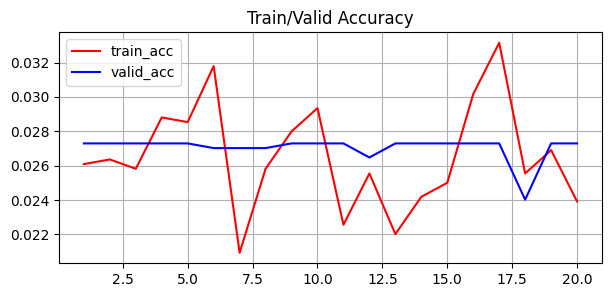

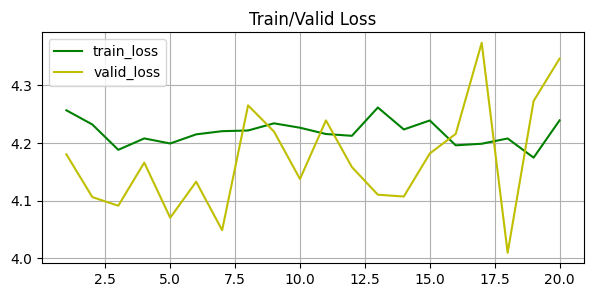

In [ ]:
# plt.figure(figsize=(7,3))
# plt.grid(True)
# # 정확도
# plt.title('Train/Valid Accuracy')
# plt.plot(range(1, len(train_acc_history)+1), train_acc_history,
#          color='r', label='train_acc')
# plt.plot(range(1, len(valid_acc_history)+1), valid_acc_history,
#          color='b', label='valid_acc')
# plt.legend()
# plt.show()

# # 손실값
# plt.figure(figsize=(7,3))
# plt.grid(True)
# plt.title('Train/Valid Loss')
# plt.plot(range(1, len(train_loss_history)+1), train_loss_history,
#          color='g', label='train_loss')
# plt.plot(range(1, len(valid_loss_history)+1), valid_loss_history,
#          color='y', label='valid_loss')
# plt.legend()
# plt.show()